# Dataset

In [1]:
import pickle
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile, expandvars

# data
irf = 'random' 
table = 'regressor_5sgm_xy_flip.pickle'
path = f'{expandvars("$HOME")}/E4/irf_{irf}/crab/'
dataset = join(path, table)

# models
cnnname = 'cleaner_5sgm_filter12_z20'
savename = 'regressor_5sgm_filter6_4convs_dense1e4_z20' 

# dataset 
if '.pickle' in table:
    with open(dataset,'rb') as f: ds = pickle.load(f)
    infotable = join(path, table.replace('.pickle', '.dat'))
    gammatable = join(path, table.replace('.pickle', '_gammapy.txt'))
elif '.npy' in table:
    ds = np.load(dataset, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
    infotable = join(path, table.replace('.npy', '.dat'))
    gammatable = join(path, table.replace('.npy', '_gammapy.txt'))
    
ds = np.array(ds['DS'])
ds = ds.reshape(ds.shape[0], ds.shape[1], ds.shape[2], 1)
ds.shape

(20000, 200, 200, 1)

# Info table

In [2]:
infodata = pd.read_csv(infotable, sep=' ', header=0).sort_values(by=['seed'])
infodata.head()

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
15000,crab_00001,1,0,100,100,57.265654,30.447065,57.253328,30.454269,0.012838,North_z40_S_0.5h_LST,2.5,7.322825
15001,crab_00002,2,0,100,100,98.177801,40.950640,98.016897,41.081760,0.178695,North_z60_N_50h_LST,2.5,6.762409
15002,crab_00003,3,0,100,100,76.984211,-66.348920,78.358890,-67.138246,0.957894,North_z40_N_5h_LST,2.5,7.029939
15003,crab_00004,4,0,100,100,125.495725,-44.424075,126.479118,-43.608941,1.079135,North_z40_5h_LST,2.5,7.074566
15004,crab_00005,5,0,100,100,214.162576,42.736282,215.790559,43.357500,1.342109,North_z20_5h_LST,2.5,7.087336


# Gamma table

In [3]:
gammatable = join(path, 'regressor_5sgm_gp_exact.txt')
gammadata = pd.read_csv(gammatable, sep=' ', header=0).sort_values(by=['seed'])
gammadata.head()

,seed,loc_ra,loc_dec,counts_on,counts_off,excess,excess_err,sigma
0,8001,356.480827,36.928221,NaN,NaN,NaN,NaN,NaN
1,8002,144.683004,6.645401,NaN,NaN,NaN,NaN,NaN
2,8003,266.264843,1.234864,NaN,NaN,NaN,NaN,NaN
3,8004,78.571839,53.389985,NaN,NaN,NaN,NaN,NaN
4,8005,329.225018,31.153194,NaN,NaN,NaN,NaN,NaN


In [4]:
len(gammadata)

2000

# CNN cleaner

In [5]:
import tensorflow as tf

root = f'{expandvars("$HOME")}/astroAI/astroai/'
model = tf.keras.models.load_model(join(root, 'models/crta_models', f'cleaner_zALL.keras'))
predictions = model.predict(ds)

2024-06-10 17:47:37.000639: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 17:47:37.000696: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 17:47:37.000708: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-10 17:47:37.009258: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 17:47:41.712135: E te

625/625 [==============================] - 20s 31ms/step


2024-06-10 17:48:20.162970: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3200000000 exceeds 10% of free system memory.


In [6]:
len(predictions)

20000

# CNN regressor

In [7]:
import tensorflow as tf
binning = 200

model = tf.keras.models.load_model(f'../models/crta_models/regressor_zALL.keras')

In [8]:
candidates = model.predict(predictions) * binning
len(candidates)

2024-06-10 17:48:53.467178: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3200000000 exceeds 10% of free system memory.


625/625 [==============================] - 32s 50ms/step


20000

# Seed

In [11]:
idx = 8000 + np.random.choice(range(len(gammadata)))
# find seed to get the original heatmap
#idx = 8592
seed = idx + 1
print('Seed:', seed)

Seed: 8117


In [12]:
row = infodata[infodata['seed']==seed]
row

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
8116,crab_08117,8117,0,100,100,8.846959,-9.043548,9.48531,-8.504044,0.830104,North_z20_50h_LST,2.5,7.068218


In [13]:
grow = gammadata[gammadata['seed']==seed]
grow

,seed,loc_ra,loc_dec,counts_on,counts_off,excess,excess_err,sigma
116,8117,8.839771,-9.066015,NaN,NaN,NaN,NaN,NaN


# WCS

In [14]:
from astroai.tools.utils import *

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)

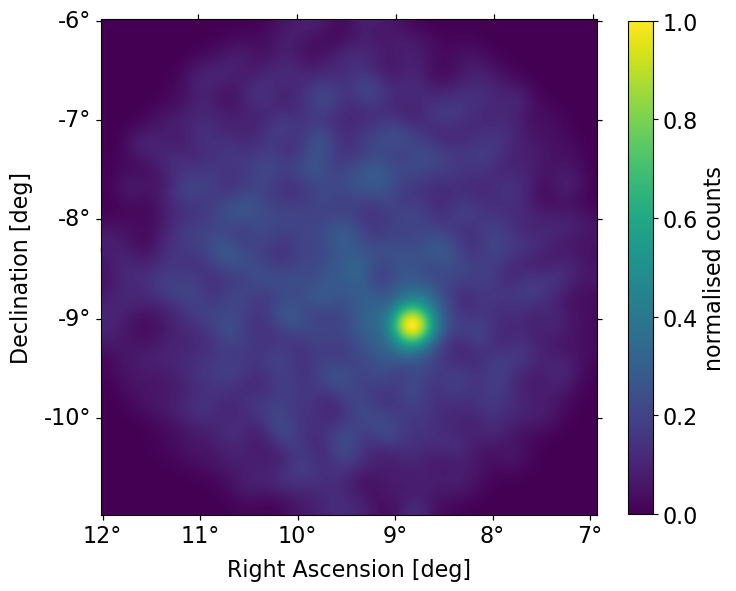

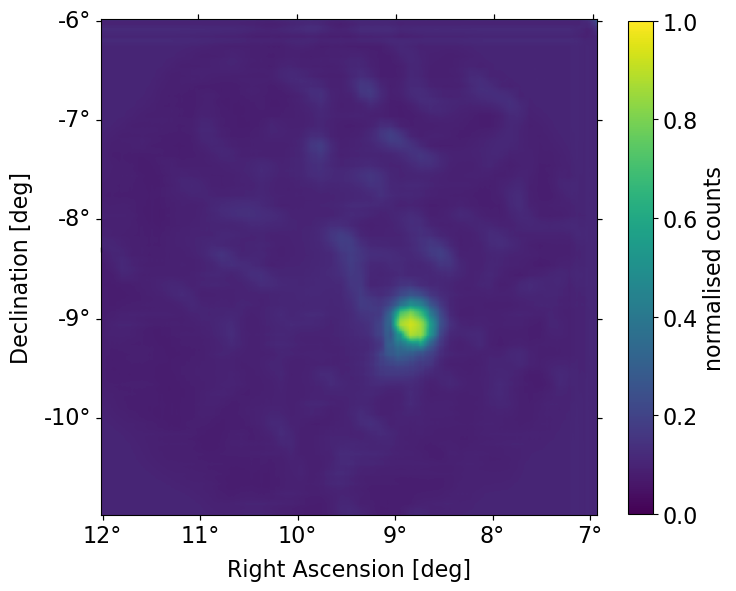

In [15]:
import astropy.units as u
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025
figsize = (8, 8)
fs = 16

# NOISY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)
    
img = ax.imshow(ds[idx], vmin=0, vmax=1)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'noisy map {seed}', fontsize=fs*1.5)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

plt.show()
fig.savefig(f'img/talk_map_{seed}_noisy.png')

# CLEAN
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)
img = ax.imshow(predictions[idx], vmin=0, vmax=1)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'clean map {seed}', fontsize=fs*1.5)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

plt.show()
fig.savefig(f'img/talk_map_{seed}_clean.png')

# Find coordinates (pix and sky)

In [16]:
from astroai.tools.utils import *

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)

# TRUE
true_sky = SkyCoord(ra=row['source_ra'].values[0], dec=row['source_dec'].values[0], unit='deg', frame='icrs')
x, y = w.world_to_pixel(true_sky) 
true_sky = true_sky.ra.deg, true_sky.dec.deg
true_pix = x, y

# PREDICTION
pred_pix = candidates[idx]
sky = w.pixel_to_world(pred_pix[0], pred_pix[1])
pred_sky = sky.ra.deg, sky.dec.deg

# GAMMAPY
gamma_sky = SkyCoord(ra=grow['loc_ra'].values[0], dec=grow['loc_dec'].values[0], unit='deg', frame='icrs')
x, y = w.world_to_pixel(gamma_sky) 
gamma_sky = gamma_sky.ra.deg, gamma_sky.dec.deg
gamma_pix = x, y

print(f'SEED: {seed}')
print('---- PIX')
print(f"true: {true_pix}")
print(f"prediction: {pred_pix}")
print(f"gammapy: {gamma_pix}")
print('---- SKY')
print(f"true: {true_sky} ")
print(f"prediction: {pred_sky}")
print(f"gammapy: {gamma_sky}")

SEED: 8117
---- PIX
true: (array(124.24274587), array(77.42405241))
prediction: [123.555374  74.495636]
gammapy: (array(124.52521429), array(76.52493371))
---- SKY
true: (8.846959001045374, -9.043548402361353) 
prediction: (8.864239967467482, -9.116786644751137)
gammapy: (8.839770806626928, -9.066014638961525)


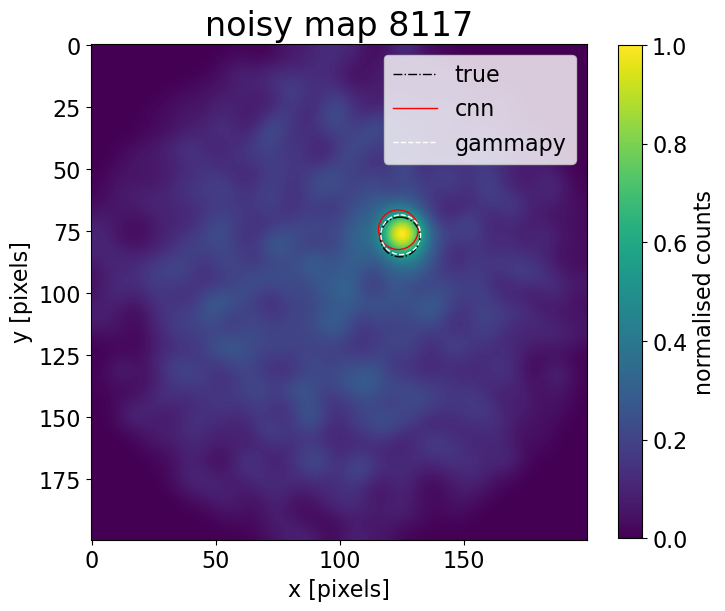

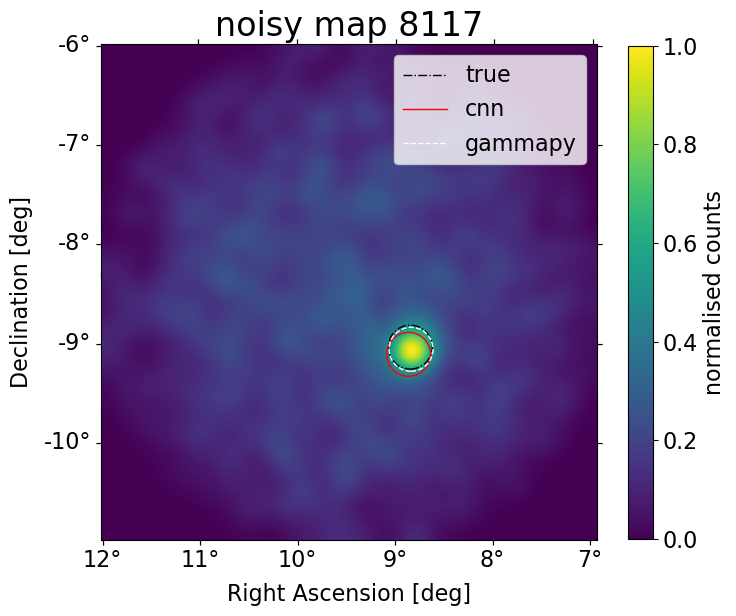

In [17]:
import astropy.units as u
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025

# LEGENDS
custom_labels = ['true', 'cnn', 'gammapy']
custom_lines = [Line2D([0], [0], color='k', lw=1, ls='-.'),
                Line2D([0], [0], color='r', lw=1, ls='-'),
                Line2D([0], [0], color='w', lw=1, ls='--')]

# PIX
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
img = ax.imshow(ds[idx], vmin=0, vmax=1)
ax.add_patch(plt.Circle((true_pix), radius=radius_pix, edgecolor='k', facecolor='none', ls='-.'))
ax.add_patch(plt.Circle((pred_pix), radius=radius_pix, edgecolor='r', facecolor='none', ls='-'))
ax.add_patch(plt.Circle((gamma_pix), radius=radius_pix, edgecolor='w', facecolor='none', ls='--'))
ax.set_ylabel('y [pixels]', fontsize=fs)
ax.set_xlabel('x [pixels]', fontsize=fs)
#ax.set_title(f'noisy map {seed}', fontsize=fs*1.5)
ax.legend(custom_lines, custom_labels, fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

plt.show()

# SKY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)
img = ax.imshow(ds[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.scatter(true_sky[0], true_sky[1], transform=ax.get_transform('icrs'), s=1e3,
              edgecolor='k', facecolor='none', ls='-.')
ax.scatter(pred_sky[0], pred_sky[1], transform=ax.get_transform('icrs'), s=1e3,
              edgecolor='r', facecolor='none', ls='-')
ax.scatter(gamma_sky[0], gamma_sky[1], transform=ax.get_transform('icrs'), s=1e3,
              edgecolor='w', facecolor='none', ls='--')
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'noisy map {seed}', fontsize=fs*1.5)
ax.legend(custom_lines, custom_labels, fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

plt.show()

In [ ]:
import astropy.units as u
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025

# LEGENDS
custom_labels = ['true', 'cnn', 'gammapy']
custom_lines = [Line2D([0], [0], color='k', lw=1, ls='-.'),
                Line2D([0], [0], color='r', lw=1, ls='-'),
                Line2D([0], [0], color='w', lw=1, ls='--')]

# PIX
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
img = ax.imshow(predictions[idx], vmin=0, vmax=1)
ax.add_patch(plt.Circle((true_pix), radius=radius_pix, edgecolor='k', facecolor='none', ls='-.'))
ax.add_patch(plt.Circle((raw_pred_pix), radius=radius_pix, edgecolor='r', facecolor='none', ls='-'))
ax.add_patch(plt.Circle((gamma_pix), radius=radius_pix, edgecolor='w', facecolor='none', ls='--'))
ax.set_ylabel('y [pixels]', fontsize=fs)
ax.set_xlabel('x [pixels]', fontsize=fs)
ax.set_title(f'clean map {seed}', fontsize=fs*1.5)
ax.legend(custom_lines, custom_labels, fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

plt.show()

# SKY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)
img = ax.imshow(predictions[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.scatter(true_sky[0], true_sky[1], transform=ax.get_transform('icrs'), s=1e3,
              edgecolor='k', facecolor='none', ls='-.')
ax.scatter(raw_pred_sky[0], raw_pred_sky[1], transform=ax.get_transform('icrs'), s=1e3,
              edgecolor='r', facecolor='none', ls='-')
ax.scatter(gamma_sky[0], gamma_sky[1], transform=ax.get_transform('icrs'), s=1e3,
              edgecolor='w', facecolor='none', ls='--')
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
ax.set_title(f'clean map {seed}', fontsize=fs*1.5)
ax.legend(custom_lines, custom_labels, fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

plt.show()

# NO GAMMAPY

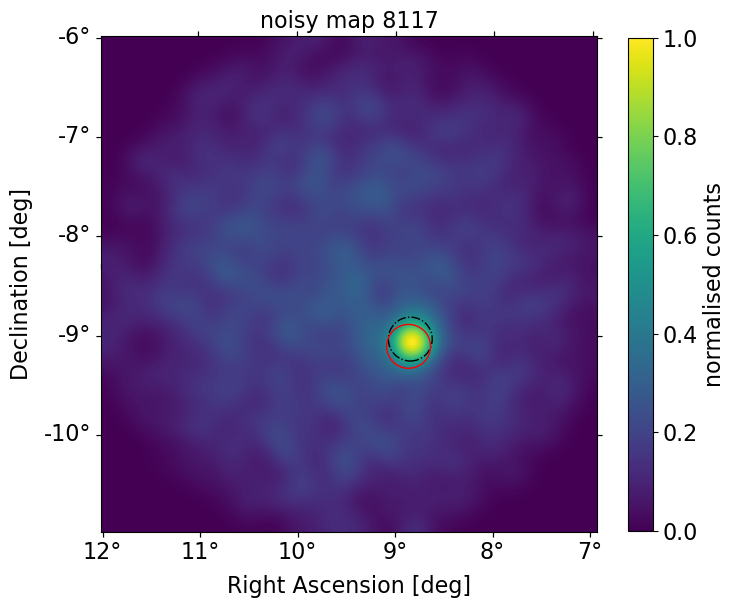

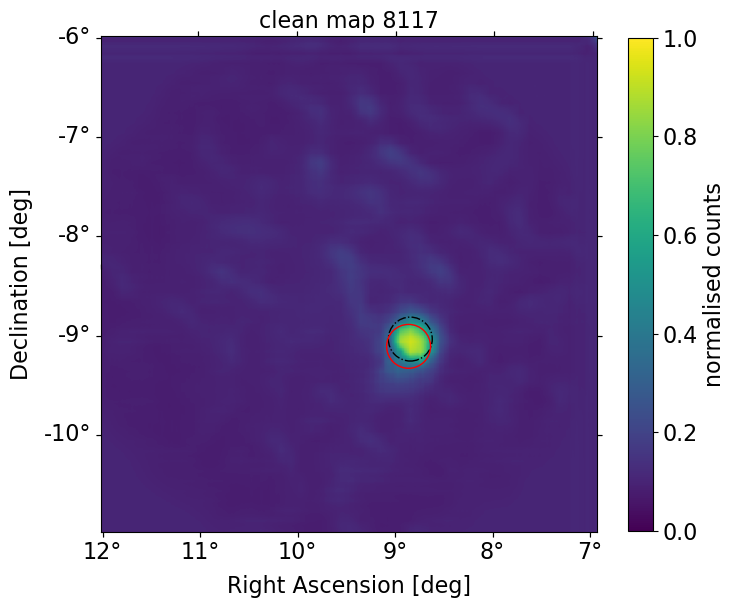

In [23]:
# LEGENDS
custom_lines = [Line2D([0], [0], color='k', lw=1, ls='-.'),
                Line2D([0], [0], color='r', lw=1, ls='-')]
custom_labels = ['true', 'cnn']

# SKY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)
img = ax.imshow(ds[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.scatter(true_sky[0], true_sky[1], transform=ax.get_transform('icrs'), s=1e3,
              edgecolor='k', facecolor='none', ls='-.')
ax.scatter(pred_sky[0], pred_sky[1], transform=ax.get_transform('icrs'), s=1e3,
              edgecolor='r', facecolor='none', ls='-')
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'noisy map {seed}', fontsize=fs)
ax.legend(custom_lines, custom_labels, fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

plt.show()

# SKY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)
img = ax.imshow(predictions[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.scatter(true_sky[0], true_sky[1], transform=ax.get_transform('icrs'), s=1e3,
              edgecolor='k', facecolor='none', ls='-.')
ax.scatter(pred_sky[0], pred_sky[1], transform=ax.get_transform('icrs'), s=1e3,
              edgecolor='r', facecolor='none', ls='-')
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'clean map {seed}', fontsize=fs)
ax.legend(custom_lines, custom_labels, fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

plt.show()

# Labels only

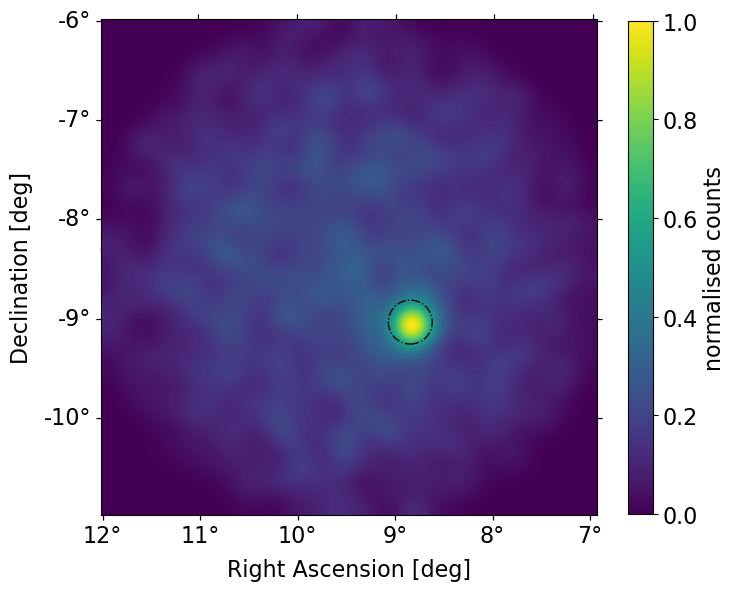

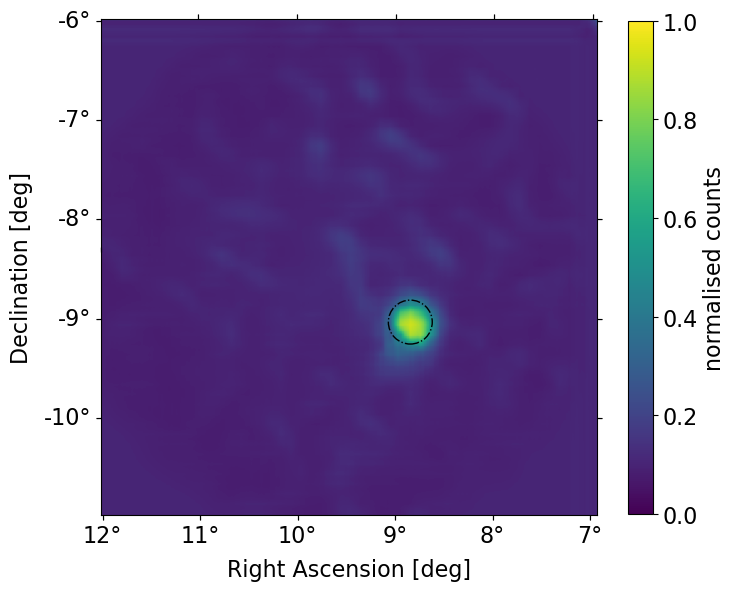

In [22]:
# LEGENDS
custom_lines = [Line2D([0], [0], color='k', lw=1, ls='-.')]
custom_labels = ['target']

# SKY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)
img = ax.imshow(ds[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.scatter(true_sky[0], true_sky[1], transform=ax.get_transform('icrs'), s=1e3,
              edgecolor='k', facecolor='none', ls='-.')
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'noisy map {seed}', fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

plt.show()

# SKY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)
img = ax.imshow(predictions[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.scatter(true_sky[0], true_sky[1], transform=ax.get_transform('icrs'), s=1e3,
              edgecolor='k', facecolor='none', ls='-.')
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'clean map {seed}', fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

plt.show()